# Final Problem Set for Physics 5300 


## Double (and more) pendulum

Solves the double pendulum and plots the two angles as a function of time for given initial conditions using either Lagrangian or Hamiltonian. 

* Last revised 16-Apr-2019 by Ness Mayker (mayker.1@osu.edu).

## Kinetic Energy

For a double pendulum, the kinetic energy (T) is

$\begin{align}
  T = \frac12(m_1+m_2)L_1^2\dot\phi_1^2 +m_2L_1L_2\dot\phi_1\dot\phi_2\cos(\phi_1-\phi_2)+\frac12 m_2L_2^2\dot\phi_2^2
\end{align}$

## Potential Energy

The potential energy (U) is

$\begin{align}
  U(\phi_1,\phi_2) = (m_1+m_2)gL_1(1-\cos\phi_1) +m_2gL_2(1-\cos\phi_2)
\end{align}$

## Lagrangian

For a double pendulum, the Lagrangian with generalized coordinates $\phi_1$ and $\phi_2$ is

$\begin{align}
  \mathcal{L} = \frac12(m_1+m_2)L_1^2\dot\phi_1^2 +m_2L_1L_2\dot\phi_1\dot\phi_2\cos(\phi_1-\phi_2)+\frac12 m_2L_2^2\dot\phi_2^2 - [(m_1+m_2)gL_1(1-\cos\phi_1) +m_2gL_2(1-\cos\phi_2)]
\end{align}$

## Euler-Lagrange equations

The Euler-Lagrange equations are

$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot\phi_1} = \frac{\partial\mathcal L}{\partial\phi_1}
 \quad\Longrightarrow\quad
 (m_1+m_2)L_1^2\ddot\phi_1 = -m_2L_1L_2\ddot\phi_2\cos(\phi_1-\phi_2)-m_2L_1L_2\dot\phi_2^2\sin(\phi_1-\phi_2)-(m_1+m_2)gL_1\sin\phi_1
  \;.
\end{align}$

$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot\phi_2} = \frac{\partial\mathcal L}{\partial\phi_2}
 \quad\Longrightarrow\quad
 m_2L_2^2\ddot\phi_2 = -m_2L_1L_2\ddot\phi_1\cos(\phi_1-\phi_2)+m_2L_1L_2\dot\phi_1^2\sin(\phi_1-\phi_2)-m_2gL_2\sin\phi_2
  \;.
\end{align}$


$\begin{align}
  \ddot\phi_1 = \frac{-m_2\dot\phi_1^2\sin(\phi_1-\phi_2)\cos(\phi_1-\phi_2)+\frac{g}{L_1}\sin(\phi_2)\cos(\phi_1-\phi_2)-m_2L_1L_2\dot\phi_2^2\sin(\phi_1-\phi_2)-(m_1+m_2)gL_1\sin(\phi_1)}{m_1+m_2\sin^2(\phi_1-\phi_2)}
\end{align}$    
    

$\begin{align}
  \ddot\phi_2 = \frac{-L_1}{L_2}\ddot\phi_1\cos(\phi_1-\phi_2)+\frac{L_1}{L_2}\dot\phi_1^2\sin(\phi_1-\phi_2)-\frac{g}{L_2}\sin(\phi_2)
\end{align}$  

In [1]:
%matplotlib notebook

import numpy as np
from scipy.integrate import odeint, solve_ivp

import matplotlib.pyplot as plt

# The dpi (dots-per-inch) setting will affect the resolution and how large
#  the plots appear on screen and printed.  So you may want/need to adjust 
#  the figsize when creating the figure.
plt.rcParams['figure.dpi'] = 80.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 10
plt.rcParams.update({'font.size': font_size})

### Double Pendulum Classes & Utility Functions

In [2]:
class DoublePendulum():
    """
    Pendulum class implements the parameters and Lagrangian equations for 
     a double pendulum.

    Parameters
    ----------
    L1 : float
        length of the first pendulum
    L2 : float
        length of the second pendulum
    m1 : float
        mass of first pendulum bob
    m2 : float
        mass of second pendulum bob
    g : float
        gravitational acceleration at the earth's surface

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    def __init__(self, L1=1., L2=1., m1=1., m2=1., g=1.
                ):
        self.L1 = L1
        self.L2 = L2
        self.m1 = m1
        self.m2 = m2
        self.g = g
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dphi_1/dt, dphi_2/dt, dphi_1^2/dt^2, dphi_2^2/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 4-component vector with y[0] = phi_1(t), y[1] = phi_2(t), y[2] = dphi_1/dt, y[3] = dphi_2/dt           
        Returns
        -------
        """
        phi1    = y[0]
        phi2    = y[1]
        phi1dot = y[2]
        phi2dot = y[3]
        c, s    = np.cos(phi1-phi2), np.sin(phi1-phi2)
        L1 = self.L1
        L2 = self.L2
        m1 = self.m1 
        m2 = self.m2 
        M  = m1 + m2
        g  = self.g
                   
        phi1ddot = ((-m2*phi1dot**2*s*c)+((g/L1)*np.sin(phi2)*c)-(m2*L1*L2*phi2dot**2*s)-(M*g*L1*np.sin(phi1)))/(m1+m2*s**2)
        phi2ddot  = (-L1/L2*phi1ddot*c)+(L1/L2*phi1dot**2*s)-(g/L2*np.sin(phi2)) 
        
        return [y[2], y[3], phi1ddot, phi2ddot]
    
    def solve_ode(self, t_pts, phi1_0, phi2_0, phi_dot1_0, phi_dot2_0, 
                  abserr=1.0e-9, relerr=1.0e-9):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [phi1_0, phi2_0, phi_dot1_0, phi_dot2_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        phi1, phi2, phi_dot1, phi_dot2 = solution.y

        return phi1, phi2, phi_dot1, phi_dot2

### Set up Generic Plotting Function

In [3]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [4]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

### Make Double Pendulum Plots

In [5]:
# Labels for individual plot axes
phi_vs_time_labels = (r'$t$', r'$\phi(t)$')
phi_dot_vs_time_labels = (r'$t$', r'$d\phi/dt(t)$')
state_space_labels = (r'$\phi$', r'$d\phi/dt$')
delta_phi_vs_time_labels = (r'$t$', r'$\delta\phi(t)$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 50.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

#initial conditions for physical construction of pendulum
L1 = 1.
L2 = 1.
g  = 1.
m1 = 1.
m2 = 1.

# Instantiate a pendulum 
p1 = DoublePendulum(L1=L1, L2=L2, g=g, m1=m1, m2=m2)


<IPython.core.display.Javascript object>


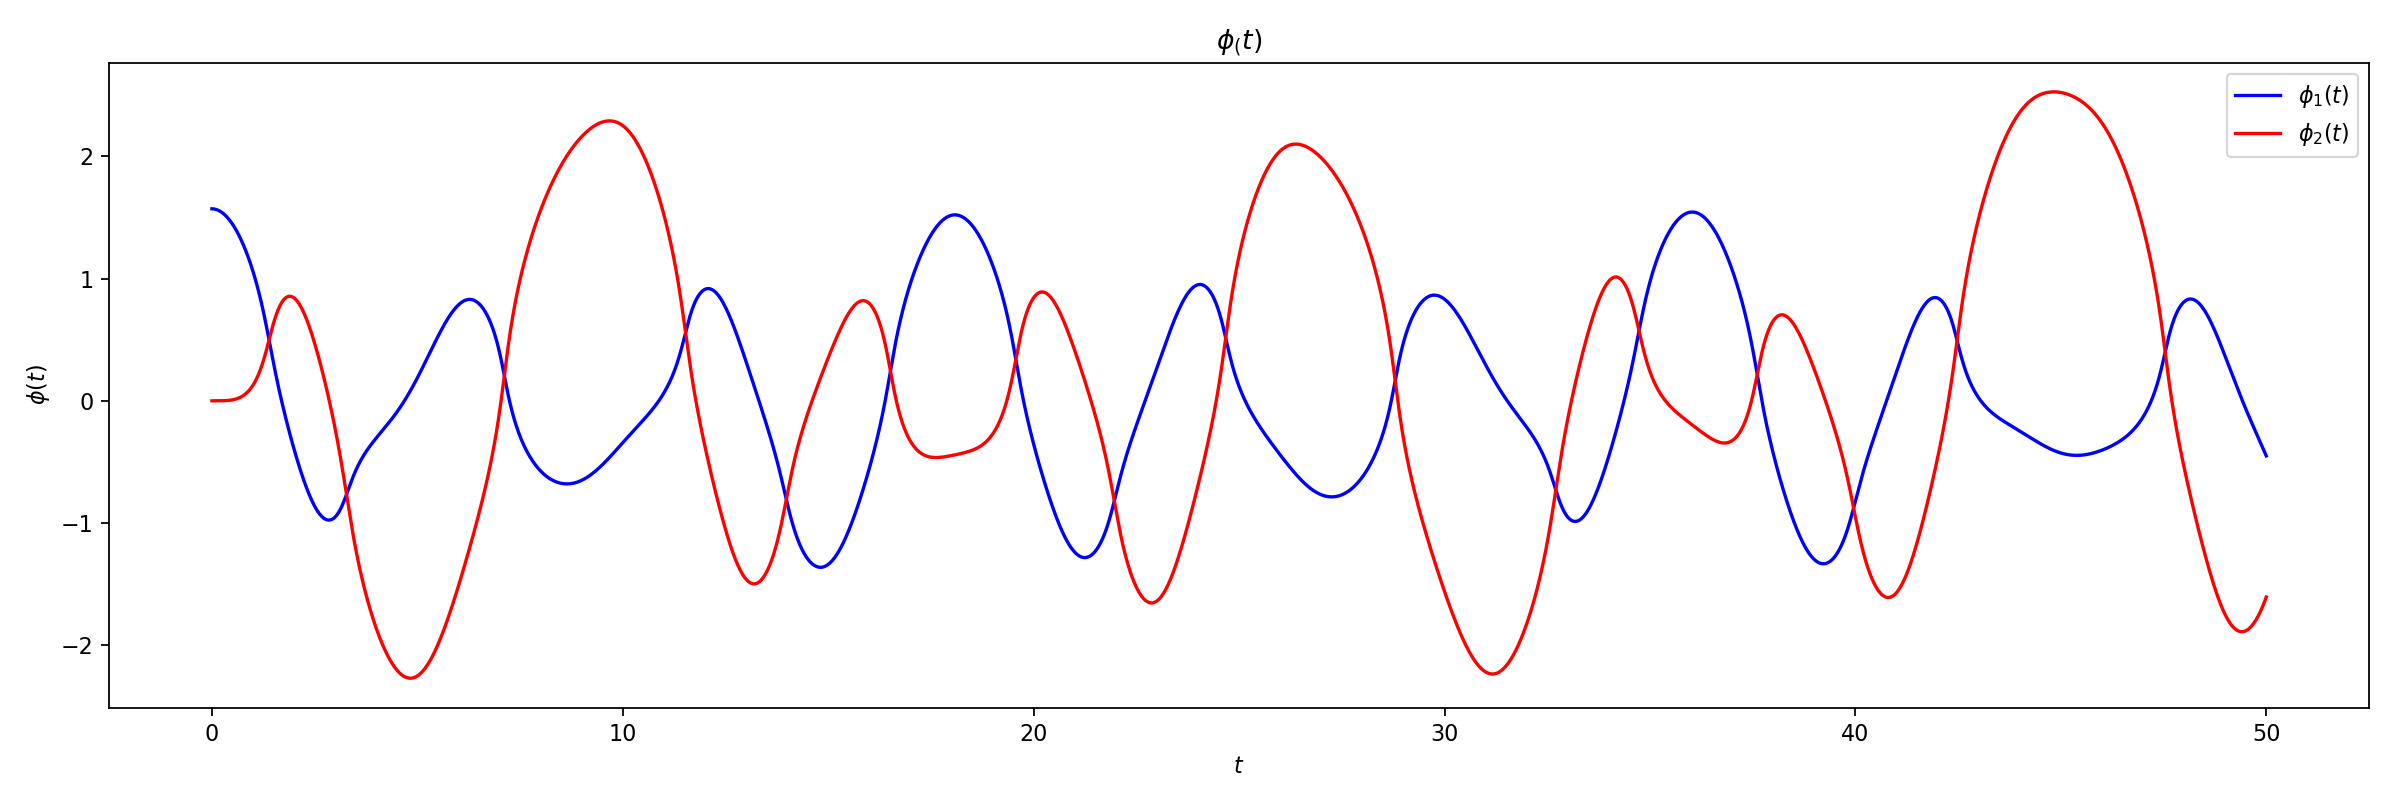

In [6]:
#set up initial conditions for starting position, velocities, etc.
phi1_0 = np.pi/2.0
phi2_0 = 0.0

phi_dot1_0 = 0.0
phi_dot2_0 = 0.0

phi1, phi2, phi_dot1, phi_dot2 = p1.solve_ode(t_pts, phi1_0, phi2_0, phi_dot1_0, phi_dot2_0)

# start the plot!
fig = plt.figure(figsize=(15,5))
overall_title = 'Double Pendulum from Lagrangian:  ' + \
                rf' $\phi1_0 = {phi1_0:.2f},$' + \
                rf'  $\phi2_0 = {phi2_0:.2f},$' + \
                rf' $\dot\phi1_0 = {phi_dot1_0:.2f}$' + \
                rf' $\dot\phi2_0 = {phi_dot2_0:.2f}$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
# plot of phi vs time for both phi values in double pendulum
start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi1[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='blue',
            label=r'$\phi_1(t)$', 
            title=r'$\phi_(t)$')    
plot_y_vs_x(t_pts[start : stop], phi2[start : stop],
            color='red',
            label=r'$\phi_2(t)$') 

fig.tight_layout()
fig.savefig('double_pendulum_phis.png', bbox_inches='tight')  


<IPython.core.display.Javascript object>


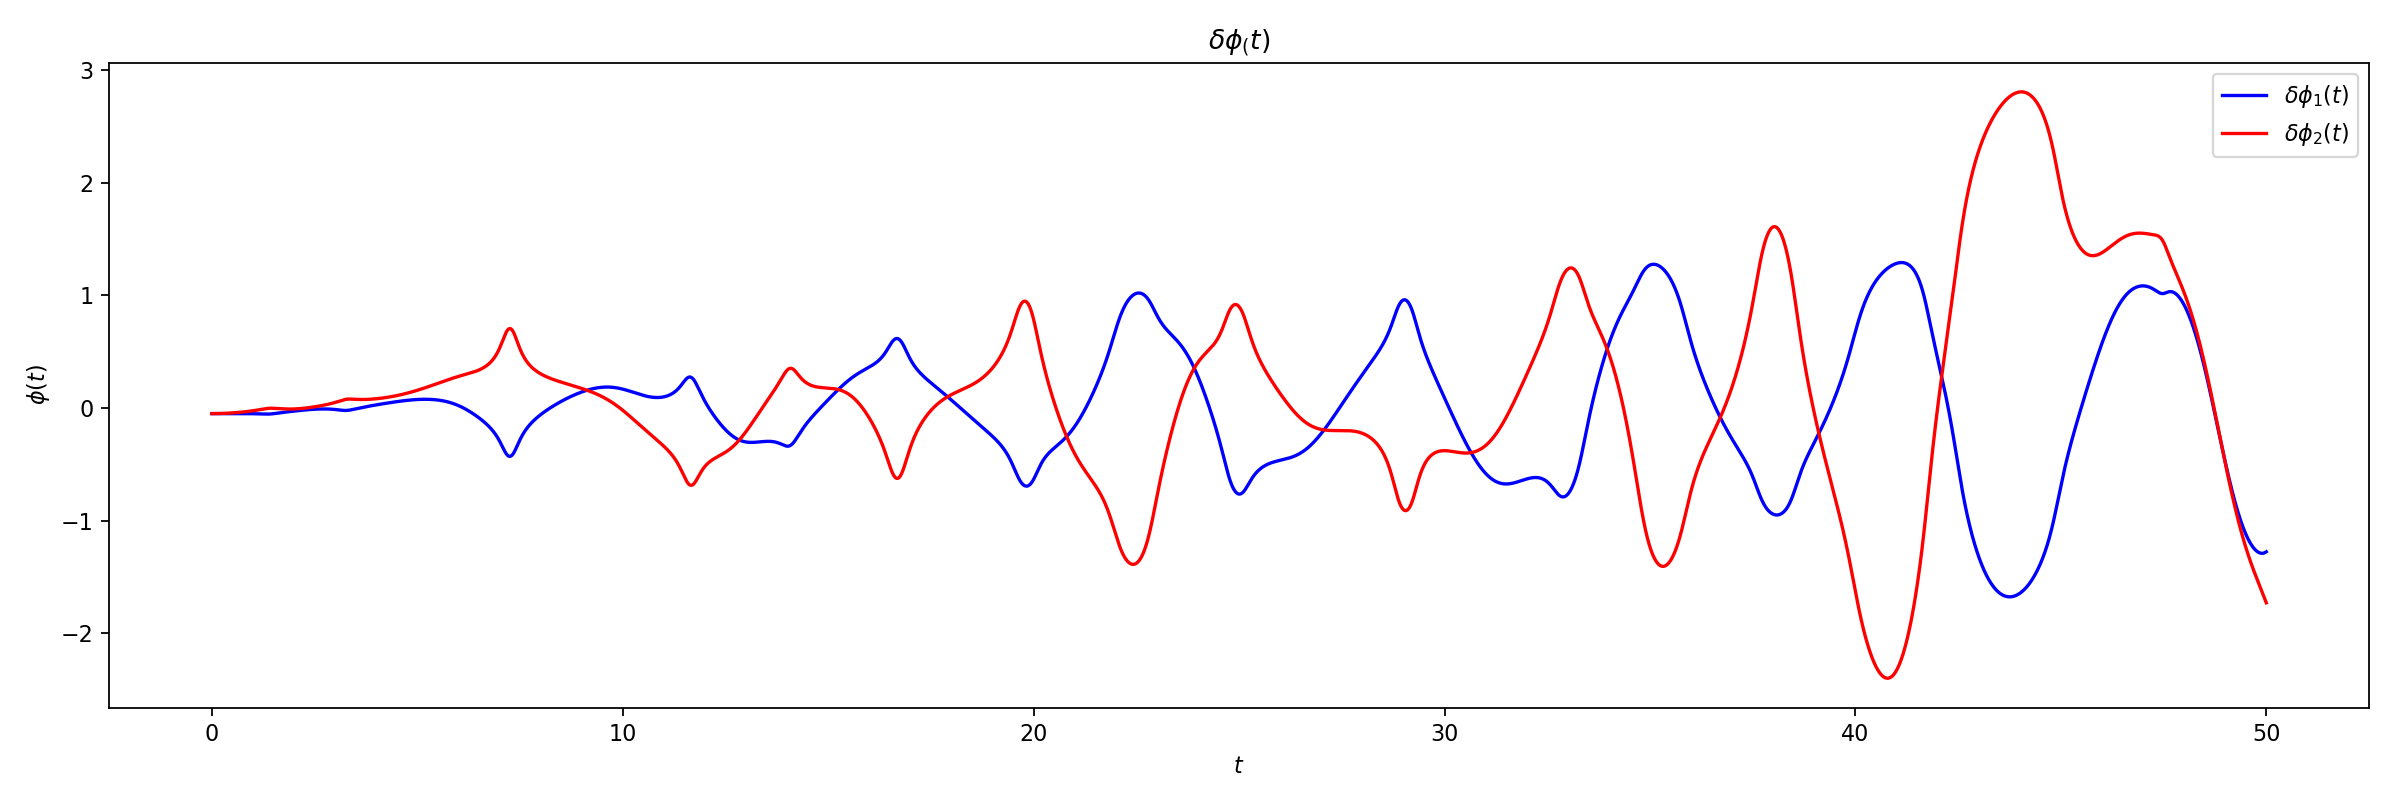

In [7]:
#run another double pendulum with slightly offset starting position to demonstrate the system is chaotic
phi1_0b, phi2_0b, phi_dot1_0b, phi_dot2_0b = phi1_0 + 0.05, phi2_0 + 0.05, phi_dot1_0, phi_dot2_0
phi1b, phi2b, phi_dot1b, phi_dot2b = p1.solve_ode(t_pts, phi1_0b, phi2_0b, phi_dot1_0b, phi_dot2_0b)
delta_phi1, delta_phi2 = phi1-phi1b, phi2-phi2b

# Delta Phi Plot to Demonstrate Chaos
fig = plt.figure(figsize=(15,5))
overall_title = 'Delta Phi:  ' + \
                rf' $\phi1_0 = {phi1_0:.2f},$' + \
                rf' $\phi1_0b = {phi1_0b:.2f},$' + \
                rf'  $\phi2_0 = {phi2_0:.2f},$' + \
                rf'  $\phi2_0b = {phi2_0b:.2f},$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
# plot of delta phi vs time for both phi values in double pendulum 
start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], delta_phi1[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='blue',
            label=r'$\delta\phi_1(t)$', 
            title=r'$\delta\phi_(t)$')    
plot_y_vs_x(t_pts[start : stop], delta_phi2[start : stop],
            color='red',
            label=r'$\delta\phi_2(t)$') 

fig.tight_layout()
fig.savefig('double_pendulum_phis.png', bbox_inches='tight')  

### Set up Animation Functions

In [8]:
from matplotlib import animation, rc
from IPython.display import HTML

class AnimationPendulumPlot():
    """
    AnimationPlot class uses matplotlib.animation.FuncAnimation to animate
     the dynamics of an oscillator.  This includes a simple time dependence
     graph, a state space graph with Poincare map, and a physical model.
     
     We'll start with a pendulum and then generalize later.
     
    Parameters
    ----------
    phi_vs_t : boolean
        If True, plot phi(t) vs. t
    
    phi_dot_vs_t : boolean
        If True, plot phi_dot(t) vs. t
    
    state_space : boolean
        If True, plot phi_dot(t) s. phi(t)
    
    physics_pend : boolean
        If True, draw the pendulum at phi(t) vs. t


    Methods
    -------
    plot_setup
    
    t_pts_init
    
    add_pendulum
    
    animate_pendulum
    
    plot_setup
    
    start_animation
    """
    def __init__(self, phi_vs_t=True, phi_dot_vs_t=False,
                 state_space=True, physical_pend=True):
        self.pendulums = []
        self.length1 = L1
        self.length2 = L2
                  
    def t_pts_init(self, t_start=0., t_end=100., delta_t=0.01): 
        """Create the array of time points for the full iteration"""
        self.t_start = t_start
        self.t_end = t_end
        self.delta_t = delta_t
        self.t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

    def add_pendulum(self, pend, phi1_0=0., phi2_0=0., phi_dot1_0=0., phi_dot2_0=0.):
        """Add a pendulum to be plotted as a class instance of Pendulum
            along with initial conditions.  So it knows all of the parameters
            as well through the Pendulum class.
        """      
        self.pend = pend
        self.phi1_0 = phi1_0
        self.phi2_0 = phi2_0
        self.phi_dot1_0 = phi_dot1_0
        self.phi_dot2_0 = phi_dot2_0
        phi1, phi2, phi_dot1, phi_dot2 = pend.solve_ode(self.t_pts, self.phi1_0, self.phi2_0, self.phi_dot1_0, self.phi_dot2_0)
        self.pendulums.append((phi1, phi2, phi_dot1, phi_dot2))
    
    def plot_setup(self, plot_start, plot_end):
        """Set up the plots to be displayed. """
        
        # Labels for individual plot axes
        phi_vs_time_labels = (r'$t$', r'$\phi(t)$')
        phi_dot_vs_time_labels = (r'$t$', r'$d\phi/dt(t)$')
        state_space_labels = (r'$\phi$', r'$d\phi/dt$')
                
        
        # make new arrays to hold phi and phi_dot information from start to finish
        self.start, self.stop = start_stop_indices(self.t_pts, plot_start, 
                                                   plot_end)
        self.t_pts_plt = self.t_pts[self.start : self.stop]
        self.pendulums_plot = []
        
        for phi_tuple in self.pendulums:
            phi1,  phi2, phi_dot1, phi_dot2 = phi_tuple
            phi1_plt = phi1[self.start : self.stop]
            phi2_plt = phi2[self.start : self.stop]
            phi_dot1_plt = phi_dot1[self.start : self.stop]
            phi_dot2_plt = phi_dot2[self.start : self.stop]
            self.pendulums_plot.append( (phi1_plt, phi2_plt, phi_dot1_plt, phi_dot2_plt) )

        self.fig = plt.figure(figsize=(10, 3.3), num='Pendulum animation')
        
        #set up the first subplot of phi(t) vs t
        self.ax_1 = self.fig.add_subplot(1,3,1)        
        self.line_1, = self.ax_1.plot(self.t_pts_plt, phi1_plt, 
                                      color='blue')
        self.line_1b, = self.ax_1.plot(self.t_pts_plt, phi2_plt, 
                                      color='red')
        self.pt_1, = self.ax_1.plot(self.t_pts_plt[0], phi1_plt[0], 
                                    'o', color='green')
        self.pt_1b, = self.ax_1.plot(self.t_pts_plt[0], phi2_plt[0], 
                                    'o', color='purple')
        self.ax_1.set_xlabel(r'$t$')
        self.ax_1.set_ylabel(r'$\phi(t)$')
        
        #set up second subplot of the double pendulum animation
        self.ax_2 = self.fig.add_subplot(1,3,2, projection='polar')
        self.ax_2.set_aspect(1)   # aspect ratio 1 subplot
        self.ax_2.set_rorigin(0.)   # origin in the middle
        self.ax_2.set_theta_zero_location('S')  # phi=0 at the bottom
        self.ax_2.set_ylim(-1.2*(self.length1+self.length2),1.2*(self.length1+self.length2))  # set up window frame to always display both pendulums
        self.ax_2.grid(False)   # no longitude/lattitude lines
        self.ax_2.set_xticklabels([])   # turn off angle labels
        self.ax_2.set_yticklabels([])    # turn off radial labels
        self.ax_2.spines['polar'].set_visible(False) # no circular border
        
        self.length1 = L1
        self.length2 = L2
        self.ax_2.plot(0, 0, color='black', marker='o', markersize=5)
        #draw the line for the first pendulum [(phiStart, phiEnd)][(rStart, rEnd)]
        self.line_2, = self.ax_2.plot([phi1_plt[0], phi1_plt[0]], 
                                      [0.,self.length1], 
                                      color='blue', lw=3)
    
        #locate the origin of the second pendulum
        Length2 = self.length1 * np.sin(phi1_plt[0]) + self.length2 * np.sin(phi2_plt[0])
        Length1 = self.length1 * np.cos(phi1_plt[0]) + self.length2 * np.cos(phi2_plt[0])
        alpha2 = np.arctan2(Length2, Length1)
        r2 = np.sqrt(Length1**2 + Length2**2) 
        
        #draw the line for the second pendulum [(phiStart, phiEnd)][(rStart, rEnd)]
        self.line_2b, = self.ax_2.plot([phi1_plt[0], alpha2], 
                                      [self.length1,r2], 
                                      color='red', lw=3)
        
        #assign points to be the mass at the end of each pendulum
        self.pt_2, = self.ax_2.plot(phi1_plt[0], self.length1, 
                                    marker='o', markersize=15, color='green')
        self.pt_2b, = self.ax_2.plot(alpha2, r2, 
                                    marker='o', markersize=15, color='purple')
        
        #set up text display that reports the phi values during the animation
        phi1_string = rf'$\phi = {phi1_plt[0]: .1f}$'
        self.phi1_text = self.ax_2.text(np.pi+0.4, 2., phi1_string, 
                                       horizontalalignment='center') 
        phi2_string = rf'$\phi = {phi2_plt[0]: .1f}$'
        self.phi2_text = self.ax_2.text(np.pi-0.4, 2., phi2_string, 
                                       horizontalalignment='center')
        
        #set up for third plot of phi vs phiDot
        self.ax_3 = self.fig.add_subplot(1,3,3)
        self.line_3, = self.ax_3.plot(phi1_plt, phi_dot1_plt, 
                                      color='blue')
        self.pt_3, = self.ax_3.plot(phi1_plt[0], phi_dot1_plt[0], 
                                    'o', color='green')
        self.line_3b, = self.ax_3.plot(phi2_plt, phi_dot2_plt, 
                                      color='red')
        self.pt_3b, = self.ax_3.plot(phi2_plt[0], phi_dot2_plt[0], 
                                    'o', color='purple')        
        self.ax_3.set_xlabel(r'$\phi$')
        self.ax_3.set_ylabel(r'$\dot\phi$')
        
        self.fig.tight_layout()
        
    #takes pendulum from initial condition and evaluates parameters along specified time frame at each timestep
    def animate_pendulum(self, i, t_pts_skip, phi1_skip, phi2_skip, phi_dot1_skip, phi_dot2_skip):
        self.pt_1.set_data(t_pts_skip[i], phi1_skip[i])

        self.line_2.set_data([phi1_skip[i], phi1_skip[i]], [0., self.length1])
        self.pt_2.set_data(phi1_skip[i], self.length1)
        phi1_string = rf'$\phi1 = {phi1_skip[i]: .1f}$'
        self.phi1_text.set_text(phi1_string)
        
        #locate the origin of the second pendulum at each point in time
        Length2 = self.length1 * np.sin(phi1_skip[i]) + self.length2 * np.sin(phi2_skip[i])
        Length1 = self.length1 * np.cos(phi1_skip[i]) + self.length2 * np.cos(phi2_skip[i])
        alpha2 = np.arctan2(Length2, Length1)
        r2 = np.sqrt(Length1**2 + Length2**2) 

        #assign new values at each time step
        self.pt_3.set_data(phi1_skip[i], phi_dot1_skip[i])
        self.pt_1b.set_data(t_pts_skip[i], phi2_skip[i])

        self.line_2b.set_data([phi1_skip[i], alpha2], [self.length1, r2])
        self.pt_2b.set_data(alpha2, r2)
        phi2_string = rf'$\phi2 = {phi2_skip[i]: .1f}$'
        self.phi2_text.set_text(phi2_string)
        self.pt_3b.set_data(phi2_skip[i], phi_dot2_skip[i])
        
        return self.pt_1, self.pt_2, self.phi1_text, self.pt_3, self.pt_1b, self.pt_2b, self.phi2_text, self.pt_3b
          
    #Starts and iterates through the animation    
    def start_animation(self, skip=2, interval=25.):
        self.skip = skip          # skip between points in t_pts array
        self.interval = interval  # time between frames in milliseconds
        phi1_plt, phi2_plt, phi_dot1_plt, phi_dot2_plt, = self.pendulums_plot[0]
        self.anim = animation.FuncAnimation(self.fig, self.animate_pendulum, 
                           fargs=(self.t_pts_plt[::self.skip], 
                                  phi1_plt[::self.skip],
                                  phi2_plt[::self.skip],
                                  phi_dot1_plt[::self.skip],  
                                  phi_dot2_plt[::self.skip]), 
                           init_func=None,
                           frames=len(self.t_pts_plt[::self.skip]), 
                           interval=self.interval, 
                           blit=True, repeat=False,
                           save_count=0)

        #HTML(anim.to_jshtml())
        self.fig.show()


### Add Widgets

In [9]:
# Create a pendulum animation instance. 
pendulum_anim = AnimationPendulumPlot(phi_vs_t=True, 
                                      phi_dot_vs_t=False,
                                      state_space=True,
                                      physical_pend=True)

# Common plotting time (generate the full time here then use slices below)
t_start = 0.
t_end = 100.
delta_t = 0.05
pendulum_anim.t_pts_init(t_start, t_end, delta_t)

# Pendulum parameters
phi1_0 = 0.
phi2_0 = 3./4.*np.pi
phi_dot1_0 = 0.
phi_dot2_0 = 0.
#phi1, phi2, phi_dot1, phi_dot2 = p1.solve_ode(t_pts, phi1_0, phi2_0, phi_dot1_0, phi_dot2_0)

# Instantiate a pendulum 
p1 = DoublePendulum(L1=L1, L2=L2, g=g, m1=m1, m2=m2)


# Add a pendulum to the animation plots; this solves the differential
#  equation for the full t_pts array, generating phi and phi_dot internally. 
pendulum_anim.add_pendulum(p1, phi1_0, phi2_0, phi_dot1_0, phi_dot2_0)

<IPython.core.display.Javascript object>


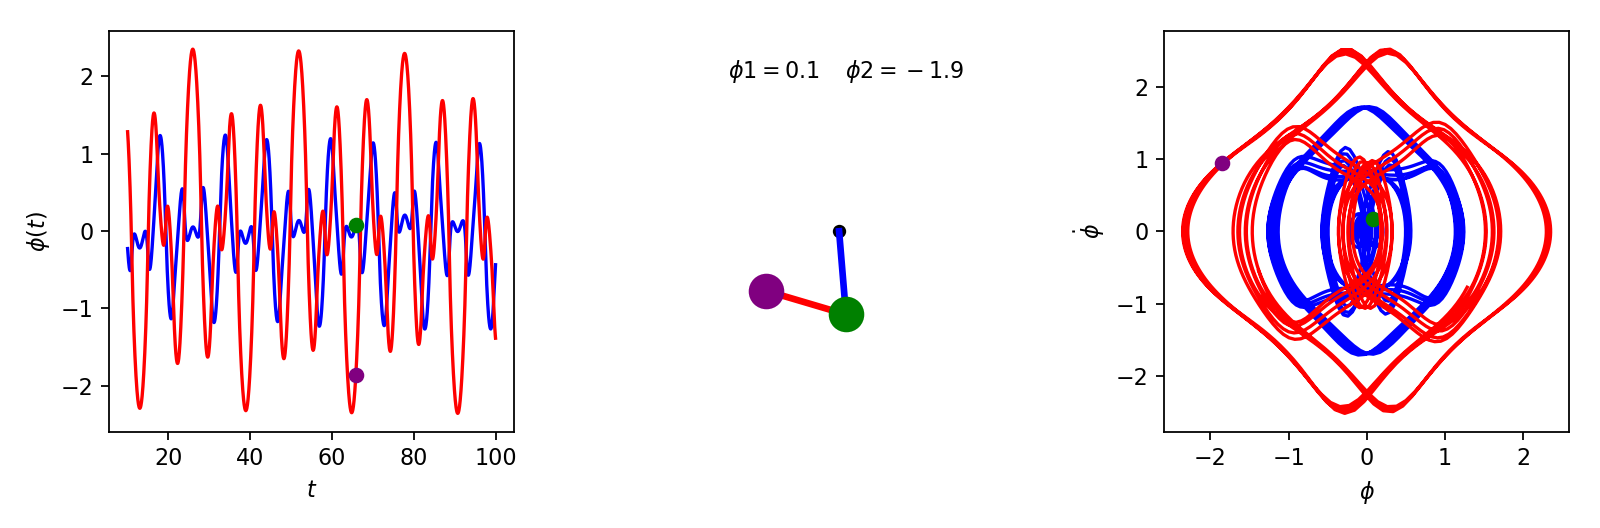

In [10]:
plot_start = 10.   # time to begin plotting
plot_end = 100.05    # time to end plotting
pendulum_anim.plot_setup(plot_start, plot_end)

# Start the animation (adjust skip and interval for a smooth plot at a 
#  useful speed)
skip = 2        # skip between time points (in units of delta_t) 
interval = 15.  # time between frames in milliseconds
pendulum_anim.start_animation(skip, interval)